In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt
import gdown
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [2]:
url = 'https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y'
output = 'Dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1lABUY5LjGAXwI_BEm2Uj35xOz5_ToO5y
To: /content/Dataset.zip
100%|██████████| 197M/197M [00:01<00:00, 104MB/s] 


'Dataset.zip'

In [3]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Preprocessed Dataset/val/altered_frames_cropped/r7B491zbxnw_0_pXJ6HOsm_iY_0.avi_frame_690.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/s8CuBT-MDYE_4_sZqIjquRfck_8.avi_frame_150.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/szxR2kMIWtI_0_saQyF1FPiqw_0.avi_frame_270.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/qpBoMZ8mAiQ_2_qpe2zydDOBM_0.avi_frame_210.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wTsoXbhr0N8_4_wnx2fsN9WP0_1.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvxJpaN72WQ_2.avi_frame_60.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/rBgM58w-gvM_1_pd8-LGKVGWQ_3.avi_frame_540.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/sZDvg03saDA_4_sZDvg03saDA_4.avi_frame_360.jpg  
  inflating: Preprocessed Dataset/val/altered_frames_cropped/wedLZCKQSrM_2_uvx

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to the input size of the model
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root='Preprocessed Dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='Preprocessed Dataset/val', transform=transform)
test_dataset = datasets.ImageFolder(root='Preprocessed Dataset/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(val_loader)
check_data_loader_dim(test_loader)

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x


In [7]:
model = SimpleCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    model.to(device)
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = outputs > 0.0
            running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1).float())
                running_loss += loss.item() * inputs.size(0)
                preds = outputs > 0.0
                running_corrects += torch.sum(preds == labels.view(-1, 1).data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

    return model, (train_losses, train_accuracies, val_losses, val_accuracies)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device=device)


Epoch 1/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 1/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 1/25
Train Loss: 0.6932 Acc: 0.4993
Validation Loss: 0.6931 Acc: 0.5001


Epoch 2/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 2/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 2/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 3/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 3/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 3/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 4/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 4/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 4/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 5/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 5/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 5/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 6/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 6/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 6/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 7/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 7/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 7/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 8/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 8/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 8/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 9/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 9/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 9/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 10/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 10/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 10/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 11/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 11/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 11/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 12/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 12/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 12/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 13/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 13/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 13/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 14/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 14/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 14/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 15/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 15/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 15/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 16/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 16/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 16/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 17/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 17/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 17/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 18/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 18/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 18/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 19/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 19/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 19/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 20/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 20/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 20/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 21/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 21/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 21/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 22/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 22/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 22/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 23/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 23/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 23/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 24/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 24/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 24/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


Epoch 25/25 - Training:   0%|          | 0/780 [00:00<?, ?batch/s]

Epoch 25/25 - Validation:   0%|          | 0/164 [00:00<?, ?batch/s]

Epoch 25/25
Train Loss: 0.6931 Acc: 0.5000
Validation Loss: 0.6931 Acc: 0.5001


In [10]:
train_accuracy = [accuracy.cpu().item() for accuracy in metrics[1]]
val_accuracy = [accuracy.cpu().item() for accuracy in metrics[3]]

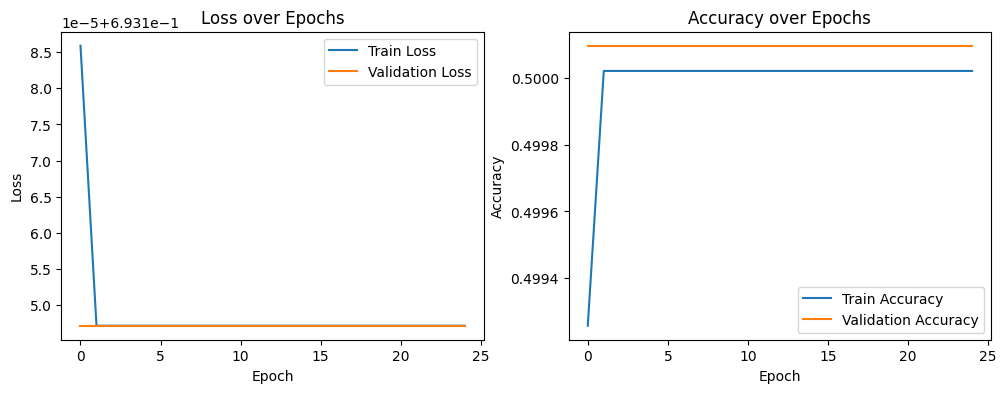

In [11]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(metrics[0], label='Train Loss')
plt.plot(metrics[2], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [12]:
torch.save(trained_model, 'Custom_CNN.pth')

In [13]:
class_names = train_dataset.classes

In [15]:
# Load the entire model
trained_model = torch.load('/content/Custom_CNN.pth')

# Set to evaluation mode for inference
trained_model.eval()

# Move model to the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [16]:
trained_model.eval()

test_loss = 0
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for data, target in test_loader:
        # Moving data to the same device as model
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = trained_model(data)

        # Compute the loss
        test_loss += criterion(output, target.view(-1, 1).float()).item()

        # Convert output probabilities to predicted class
        preds = output > 0.0

        # Count correct predictions
        correct += torch.sum(preds == target.view(-1, 1).data).item()
        total += target.size(0)

# Calculate average loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0217, Test Accuracy: 0.5000


In [17]:
trained_model.eval()

# Lists to store actual and predicted labels
actuals = []
predictions = []

# Iterate over the test_loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Get predictions from the model
    with torch.no_grad():
        outputs = trained_model(images)

    # Apply sigmoid and round to get the binary class
    predicted_labels = torch.round(torch.sigmoid(outputs)).squeeze()

    # Store the true and predicted labels
    actuals.extend(labels.cpu().numpy())
    predictions.extend(predicted_labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)

# Calculate precision, recall, f1-score, and support
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)

# Print the results
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
[[2697    0]
 [2697    0]]

Accuracy: 50.00%
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
